In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

import csv
import numpy as np

import math
import random

import pandas as pd

import os
import sys

from datetime import datetime

from matplotlib import pyplot as plt

import itertools

In [2]:
class X_Y_Tensor(Dataset):
    def __init__(self, fpath="data/Caravan/all_data.csv", record_length = 10956, n_feature = 23):
        data_raw = pd.read_csv(fpath)
        data_raw["date"] = pd.to_datetime(data_raw["date"], format="%Y-%m-%d")

        # normalization and then reshape to catchment*record*feature
        self.x = data_raw.loc[
            :, "surface_net_solar_radiation_mean":"potential_evaporation_sum"
        ]
        self.x = (self.x - self.x.mean()) / self.x.std()

        self.x = torch.tensor(torch.tensor(self.x.values, dtype=torch.float32))
        self.x = self.x.view(-1, record_length, n_feature)

    
        # normalization and then reshape to catchment*record
        self.y = data_raw["streamflow"]
        self.y = (self.y - self.y.mean()) / self.y.std()
        
        self.y = torch.tensor(self.y.values, dtype=torch.float32)
        self.y = self.y.view(-1, record_length)


    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

In [3]:
class Random_Index_Generator:
    def __init__(self, catchment_number=1180, record_length=10956):
        self.catchment_number = catchment_number
        self.record_length = record_length

    def generate_random_consecutive_numbers(
        self, n_seq=2, batch_size=64, seq_length=100
    ):
        selected_catchments = np.random.choice(
            self.catchment_number, size=batch_size, replace=False
        )

        selected_starting_index = np.random.choice(
            self.record_length - seq_length + 1, size=batch_size * n_seq, replace=True
        )

        selected_ending_index = selected_starting_index + seq_length

        return selected_catchments, selected_starting_index, selected_ending_index

In [4]:
class Batch_Generator:
    def __init__(self, dataset, index_gen):
        self.dataset = dataset
        self.index_gen = index_gen

    def get_batch(self, n_seq=2, batch_size=64, seq_length=730, n_feature=23):

        (
            selected_catchments,
            selected_starting_index,
            selected_ending_index,
        ) = self.index_gen.generate_random_consecutive_numbers(
            n_seq, batch_size, seq_length
        )

        xs_batch = torch.ones([n_seq, batch_size, seq_length, n_feature])
        ys_batch = torch.ones([n_seq, batch_size, seq_length])

        for i in range(n_seq):

            for j in range(batch_size):
                xs_batch[i, j, :, :] = self.dataset.x[
                    selected_catchments[j],
                    selected_starting_index[j + i * batch_size] : selected_ending_index[
                        j + i * batch_size
                    ],
                    :,
                ]
                ys_batch[i, j, :] = self.dataset.y[
                    selected_catchments[j],
                    selected_starting_index[j + i * batch_size] : selected_ending_index[
                        j + i * batch_size
                    ],
                ]

        return xs_batch, ys_batch

In [5]:
class TimeDistributed(nn.Module):
        # https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [6]:
class Encoder(nn.Module):
    
    def __init__(
        self, input_size, lstm_hidden_dim, fc_hidden_dims, output_dim, num_lstm_layers=1
    ):
        super(Encoder, self).__init__()

        #  LSTM layers
        self.input_size = input_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.lstm_hidden_dim,
            num_layers = self.num_lstm_layers,
            batch_first = True,
        )
        
        # LSTM to latent code
        self.fc_hidden_dims = fc_hidden_dims
        self.fc_layers = []
        for i in range((len( self.fc_hidden_dims))):
            in_dim = self.lstm_hidden_dim if i == 0 else  self.fc_hidden_dims[i - 1]
            out_dim =  self.fc_hidden_dims[i]
            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
        
        self.output_dim = output_dim
        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.output_dim )] 

        self.fc_layers = nn.Sequential(*self.fc_layers)

    def forward(self, inputs):
        self.out, (_, _) = self.lstm(inputs)
        self.out = self.fc_layers(self.out[:,-1,:])

        return self.out

In [7]:
class Decoder(nn.Module):
    def __init__(
        self, latent_dim, input_size, lstm_hidden_dim, fc_hidden_dim, num_lstm_layers=1
    ):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_size = input_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(
            self.input_size + self.latent_dim,
            self.lstm_hidden_dim,
            num_layers=self.num_lstm_layers,
            batch_first=True,
        )

        self.fc_hidden_dim = fc_hidden_dim
        self.fc1 = TimeDistributed(
            nn.Linear(self.lstm_hidden_dim, self.fc_hidden_dim), batch_first=True
        )

        self.fc2 = TimeDistributed(nn.Linear(fc_hidden_dim, 1), batch_first=True)

    def forward(self, inputs):
        self.out, (_, _) = self.lstm(inputs)
        self.out = F.relu(self.fc1(self.out))
        self.out = self.fc2(self.out)

        return self.out

In [8]:
batch_gen = Batch_Generator(X_Y_Tensor(),  Random_Index_Generator(catchment_number=1180, record_length=10956))

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_19160\3114709556.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(fpath)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_19160\3114709556.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.tensor(self.x.values, dtype=torch.float32))


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forcing_dim = 23
latent_dim = 4
encoder = Encoder(input_size=forcing_dim+1, lstm_hidden_dim=128, fc_hidden_dims=[16,8], output_dim=latent_dim, num_lstm_layers=2).to(device)
decoder = Decoder(
    latent_dim=latent_dim, input_size=forcing_dim, lstm_hidden_dim=128, fc_hidden_dim=8, num_lstm_layers=2
).to(device)

# Create optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)
criterion = nn.MSELoss()

In [10]:
losses = []

batch_size=64
n_seq=2
seq_length=365 + 365
target_seq_length = 365

for epoch in range(1000):
    for i in range(500):
        running_loss = 0.0

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # get random batch
        (xs_batch, ys_batch) = batch_gen.get_batch(n_seq=n_seq,batch_size=batch_size,seq_length=seq_length)
        
        # divide batch and pass to device         
        x0, y0, xs, ys = xs_batch[0,:,:,:], ys_batch[0,:,:], xs_batch[1:,:,:,:], ys_batch[1:,:,:]
        x0, y0, xs, ys = x0.to(device), y0.to(device), xs.to(device), ys.to(device)
        
        # pass through encoder
        codes = []
        
        for j in range(xs.shape[0]):
            xs_sub, ys_sub = (xs[j, :, :, :], ys[j,:,:])
            ys_sub = ys_sub.unsqueeze(-1)
            xys = torch.cat((xs_sub, ys_sub), 2)
            code = encoder(xys)
            code = code.expand(xys.shape[1], -1, -1).transpose(0, 1)
            codes.append(code)

        code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

        # pass through decoder
        x0 = torch.cat((code, x0), 2)
        out = decoder(x0).squeeze()

        # backprop
        loss = criterion(out[:, (seq_length-target_seq_length):], y0[:, (seq_length-target_seq_length):])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        with torch.no_grad():
            running_loss = +loss.cpu().detach().numpy()

    print(running_loss)
    losses.append(running_loss)

0.3134321
0.3752442
0.37797853
0.3052348
0.24390593
0.34083742
0.24699056
0.95647115
0.21434408
0.19360982
0.32069904
0.20927927
0.2816507
0.16326581
0.32837272
0.2604083
0.21989922
0.2719389
0.30531338
0.2734225
0.26086983
0.1301359
0.15109767
0.21238849
0.1949127
0.23113513
0.23178364
0.16090725
0.17568673
0.2870015
0.24126573
0.23109932
0.2485643
0.23544952
0.14439808
0.14704861
0.16747889
0.18617362
0.16484685
0.20702298
0.13971306
0.18868555
0.1627536
0.24348588
0.14718568
0.25735703
0.14416188
0.16944635
0.21089658
0.19072416
0.23462082
0.13932997
0.1907266
0.14704002
0.252015
0.0988418
0.21257447
0.14588319
0.19453196
0.12408638
0.21816154
0.15716587
0.14823905
0.12914105
0.12590504
0.12232378
0.16776672
0.12158889
0.10612959
0.1341983
0.1208234
0.14448595
0.1399611
0.13698709
0.14200917
0.1764884
0.2281873
0.16325946
0.16311026
0.101216994
0.16985522
0.09893938
0.12438175
0.12824488
0.08085322
0.13188462
0.1160664
0.16339676
0.14155252
0.15929097
0.13269974
0.12787275
0.1223020

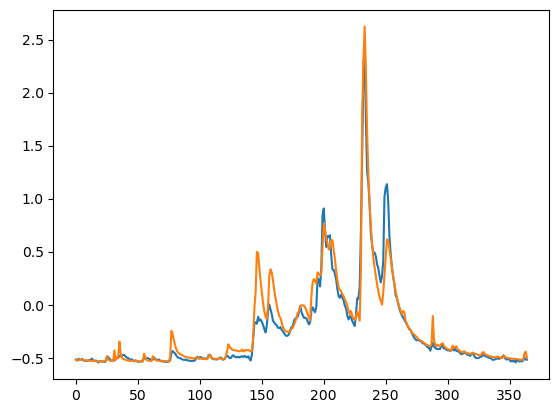

In [21]:
with torch.no_grad():
        # get random batch
        (xs_batch, ys_batch) = batch_gen.get_batch(n_seq=n_seq,batch_size=batch_size,seq_length=seq_length)
        
        # divide batch and pass to device         
        x0, y0, xs, ys = xs_batch[0,:,:,:], ys_batch[0,:,:], xs_batch[1:,:,:,:], ys_batch[1:,:,:]
        x0, y0, xs, ys = x0.to(device), y0.to(device), xs.to(device), ys.to(device)
        
        # pass through encoder
        codes = []
        
        for j in range(xs.shape[0]):
            xs_sub, ys_sub = (xs[j, :, :, :], ys[j,:,:])
            ys_sub = ys_sub.unsqueeze(-1)
            xys = torch.cat((xs_sub, ys_sub), 2)
            code = encoder(xys)
            code = code.expand(xys.shape[1], -1, -1).transpose(0, 1)
            codes.append(code)

        code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

        # pass through decoder
        x0 = torch.cat((code, x0), 2)
        out = decoder(x0).squeeze()
    
data_plot = out.cpu().detach().numpy()

plt.plot(data_plot[1, (seq_length - target_seq_length) : ])
plt.plot(y0[1, (seq_length-target_seq_length):].cpu().detach().numpy())

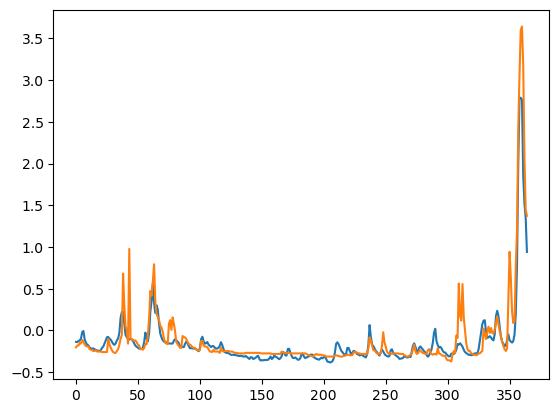

In [22]:
plt.plot(data_plot[24, (seq_length - target_seq_length) : ])
plt.plot(y0[24, (seq_length-target_seq_length):].cpu().detach().numpy())

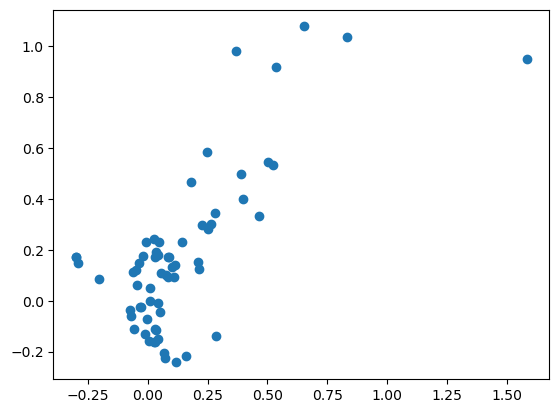

In [14]:
plt.scatter(code[:,1,2].cpu().detach().numpy(), code[:,1,3].cpu().detach().numpy())

In [20]:
torch.save(encoder, "data/Caravan/encoder.pt")
torch.save(decoder, "data/Caravan/decoder.pt")

In [25]:
code.shape

torch.Size([64, 730, 4])

In [36]:
losses = []

batch_size=64
n_seq=3
seq_length=365 + 365
target_seq_length = 365

running_loss = 0.0

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

# get random batch
(xs_batch, ys_batch) = batch_gen.get_batch(n_seq=n_seq,batch_size=batch_size,seq_length=seq_length)

In [45]:
x0, y0, xs, ys = xs_batch[0,:,:,:], ys_batch[0,:,:], xs_batch[1:,:,:,:], ys_batch[1:,:,:]
x0, y0, xs, ys = x0.to(device), y0.to(device), xs.to(device), ys.to(device)

In [46]:
# pass through encoder
codes = []
for j in range(xs.shape[0]):
    xs_sub, ys_sub = (xs[j, :, :, :], ys[j,:,:])
    ys_sub = ys_sub.unsqueeze(-1)
    xys = torch.cat((xs_sub, ys_sub), 2)
    code = encoder(xys)
    code = code.expand(xys.shape[1], -1, -1).transpose(0, 1)
    codes.append(code)

code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

In [47]:
# pass through decoder
x0 = torch.cat((code, x0), 2)
out = decoder(x0).squeeze()

In [48]:
out.shape

torch.Size([64, 730])

In [50]:
# backprop
loss = criterion(out[:, (seq_length-target_seq_length):], y0[:, (seq_length-target_seq_length):])
loss.backward()
encoder_optimizer.step()
decoder_optimizer.step()

In [38]:
j = 1
xs_sub, ys_sub = (xs[j, :, :, :], ys[j,:,:])
ys_sub = ys_sub.unsqueeze(-1)
xys = torch.cat((xs_sub, ys_sub), 2)
code = encoder(xys)

In [28]:
ys_sub.shape, xs_sub.shape
torch.cat((xs_sub, ys_sub), 2).shape

torch.Size([64, 730, 24])

In [20]:
x_0.shape, y0.shape, x_s.shape, y_s.shape

(torch.Size([64, 730, 23]),
 torch.Size([64, 730]),
 torch.Size([2, 64, 730, 23]),
 torch.Size([2, 64, 730]))

In [ ]:
with torch.no_grad():
    (x0_batch, y0_batch), (xs_batch, ys_batch) = random_batch_gen.get_batch(
            batch_size = batch_size, n_seq = n_seq, seq_length=seq_length
        )

    (x0_batch, y0_batch), (xs_batch, ys_batch) = (x0_batch.to(device), y0_batch.to(device)), (xs_batch.to(device), ys_batch.to(device)) 
    

    # pass through encoder
    codes = []
    for j in range(xs_batch.shape[1]):
        xs_batch_sub, ys_batch_sub = (xs_batch[:, j, :, :], ys_batch[:, j, :])
        ys_batch_sub = ys_batch_sub.unsqueeze(-1)
        style_inputs = torch.cat((xs_batch_sub, ys_batch_sub), 2)
        code = encoder(style_inputs)
        code = code.expand(style_inputs.shape[1], -1, -1).transpose(0, 1)
        codes.append(code)

    code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

    # pass through decoder
    x0_batch = torch.cat((code, x0_batch), 2)
    out = decoder(x0_batch).squeeze()
    
data_plot = out.cpu().detach().numpy()
plt.plot(data_plot[0, (seq_length - target_seq_length) : (seq_length - 1)])

plt.plot(data_plot[0, (seq_length - target_seq_length) : (seq_length - 1)])

In [ ]:
xs_batch, ys_batch = batch_gen.get_batch()

In [ ]:
xs_batch.shape, ys_batch.shape

(torch.Size([2, 64, 730, 23]), torch.Size([2, 64, 730]))

In [ ]:
selected_catchments, selected_starting_index, selected_ending_index = random_index_gen.generate_random_consecutive_numbers(n_seq=3, batch_size=64, seq_length=365*2)

In [ ]:
batch_size = 64
n_feature = 23
seq_length = 365 * 2
n_seq = 3

xs = torch.ones([n_seq, batch_size, seq_length, n_feature])
ys = torch.ones([n_seq, batch_size, seq_length])

for i in range(n_seq):

    for j in range(batch_size):
        xs[i, j, :, :] = all_data.x[
            selected_catchments[j],
            selected_starting_index[j + i * batch_size] : selected_ending_index[
                j + i * batch_size
            ],
            :,
        ]
        ys[i, j, :] = all_data.y[
            selected_catchments[j],
            selected_starting_index[j + i * batch_size] : selected_ending_index[
                j + i * batch_size
            ],
        ]

In [ ]:
all_data.x[selected_catchments[i], selected_starting_index[i]:selected_ending_index[i], :].shape

torch.Size([730, 23])

In [ ]:
selected_catchments, selected_starting_index, selected_ending_index = random_index_gen.generate_random_consecutive_numbers(n_seq=20, batch_size=2, seq_length=5)
print(selected_catchments, selected_starting_index, selected_ending_index)

[1 0] [2 5 2 1 0 0 5 3 0 3 3 3 2 1 1 5 4 1 5 2 2 0 1 1 2 5 1 0 0 4 0 0 3 5 4 2 5
 3 4 5] [ 7 10  7  6  5  5 10  8  5  8  8  8  7  6  6 10  9  6 10  7  7  5  6  6
  7 10  6  5  5  9  5  5  8 10  9  7 10  8  9 10]


In [ ]:
from torch import ones

x = ones(1,10)

In [ ]:
all_data.y[0:5].shape

torch.Size([5])

In [ ]:
x[:,0:10].size()

torch.Size([1, 10])

In [ ]:
x[:,1:10].shape

torch.Size([1, 9])

In [ ]:
class X_Y_Tensor(Dataset):
    def __init__(self, fpath="data/Caravan/all_data.csv"):
        data_raw = pd.read_csv(fpath)
        data_raw["date"] = pd.to_datetime(data_raw["date"], format="%Y-%m-%d")
        
        # normalization
        x = data_raw.loc[:,"surface_net_solar_radiation_mean":"potential_evaporation_sum"]
        x = (x - x.mean())/x.std()

        self.x = torch.tensor(
            torch.tensor(x.values, dtype=torch.float32)
        )
    
        self.y = torch.tensor(data_raw["streamflow"].values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

## Define functions to sample rows from dataset

`Random_Index_Generator` generates random index to select time series of the same catchment. *catchment_id* is the sequence of the ids of the catchment.

In [ ]:
class Random_Index_Generator:
    """Generating row index for subsetting X and Y tensor.
    The goal is to generate N sets of consecutive index for the same catchment (catchment_id).
    """

    def __init__(self, catchment_id):
        """Initialize the class by providing a sequence of catchment_id and corresponding quality_flag.

        Args:
            catchment_id (numpy.ndarray): Seqence of ID of catchment.
        """
        self.catchment_id = catchment_id

    def generate_random_consecutive_numbers(
        self, lower_bound: int, upper_bound: int, seq_length: int
    ) -> list:
        """Generate random consecutive numbers of length seq_length between lower_bound and upper_bound.

        Args:
            lower_bound (int): lower bound of the random sequence
            upper_bound (int): upper bound of the random sequence
            seq_length (int): length of the random sequence

        Returns:
            list: The random sequence
        """
        upper_bound = upper_bound - seq_length + 1
        s_ind = random.randint(lower_bound, upper_bound)
        e_ind = s_ind + seq_length - 1
        return list(range(s_ind, e_ind + 1))

    def generate_n_seq(self, n_seq=1, seq_length=395):
        """[summary]

        Args:
            seq_length ([type]): [description]
            n_seq (int, optional): [description]. Defaults to 1.

        Returns:
            [type]: [description]
        """
        selected_catchment_id = np.where(
            self.catchment_id == random.choice(self.catchment_id)
        )
        lower_bound, upper_bound = (
            selected_catchment_id[0][0],
            selected_catchment_id[0][-1],
        )

        out = []
        for i in range(n_seq):

            out.append(
                self.generate_random_consecutive_numbers(
                    lower_bound, upper_bound, seq_length
                )
            )

        return out

In [ ]:
class Batch_Generator:
    """[summary]"""

    def __init__(self, dataset, index_gen):
        """[summary]

        Args:
            dataset ([type]): dataset
            index_gen ([type]): generating random index
        """
        self.dataset = dataset
        self.index_gen = index_gen

    def get_batch(self, batch_size=64, n_seq=2, seq_length=395):
        """[summary]
        'n_seq' sequences are generated for each catchment, and they are expected to map to 
        the same region in the latent space.

        Args:
            batch_size (int, optional): batch size. Defaults to 64.
            n_seq (int, optional): number of sequences per catchment. Defaults to 2.
            seq_length (int, optional): length of the sequence. Defaults to 395.

        Returns:
            x0_batch and y0_batch: contain only one pair of sequence
            xs_batch and ys_batch: contain 'n_seq-1' paris of sequences
        """
        x0_batch, y0_batch = [], []
        xs_batch, ys_batch = [], []
        for i in range(batch_size):
            list_of_index = self.index_gen.generate_n_seq(n_seq, seq_length)
            list_of_batch = [self.dataset[index] for index in list_of_index]
            x0, y0 = list_of_batch[0]
            list_of_batch.pop(0)  # the first item is used by x0 and y0
            xs, ys = (
                torch.stack([x[0] for x in list_of_batch]),
                torch.stack([x[1] for x in list_of_batch]),
            )

            x0_batch.append(x0)
            y0_batch.append(y0)
            xs_batch.append(xs)
            ys_batch.append(ys)

        x0_batch, y0_batch = (torch.stack(x0_batch), torch.stack(y0_batch))
        xs_batch, ys_batch = (torch.stack(xs_batch), torch.stack(ys_batch))

        return (x0_batch, y0_batch), (xs_batch, ys_batch)

In [ ]:
data_raw = pd.read_csv("./data/Caravan/all_data.csv")

data_raw["date"] = pd.to_datetime(data_raw["date"], format="%Y-%m-%d")

# normalization
x = data_raw.loc[:,"surface_net_solar_radiation_mean":"potential_evaporation_sum"]
x = (x - x.mean())/x.std()

/var/folders/0j/tmjcqbl14mz0t6hplcmbj7yh0000gn/T/ipykernel_6510/3523123650.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("./data/Caravan/all_data.csv")


In [ ]:
x.shape
x.values[0:10,2]

array([0.2150501 , 0.181312  , 0.26105661, 0.30399601, 0.26105661,
       0.31319731, 0.27945921, 0.2150501 , 0.2089159 , 0.28405986])

In [ ]:
def new_func():
    x = torch.tensor(x.values, dtype=torch.float32)
    x.shape

new_func()

torch.Size([12928080, 23])

In [ ]:
x = x.view(-1, 10956, 23)

In [ ]:
x.shape

torch.Size([1180, 10956, 23])

In [ ]:
from torch import randint

randint()

tensor([0.2151, 0.1813, 0.2611, 0.3040, 0.2611, 0.3132, 0.2795, 0.2151, 0.2089,
        0.2841])

In [ ]:
class Random_Index_Generator:
    def __init__(self, catchment_number=1180, record_length=10956):
        self.catchment_number = catchment_number
        self.record_length = record_length

    def generate_random_consecutive_numbers(
        self, n_seq=2, batch_size=64, seq_length=100
    ):
        selected_catchments = np.random.choice(
            self.catchment_number, size=batch_size, replace=False
        )

        selected_starting_index = np.random.choice(
            self.record_length - seq_length, size=batch_size * n_seq, replace=True
        )

        selected_ending_index = selected_starting_index + seq_length

        return selected_catchments, selected_starting_index, selected_ending_index
    
random_index_gen = Random_Index_Generator()

In [ ]:
selected_catchments, selected_starting_index, selected_ending_index = random_index_gen.generate_random_consecutive_numbers()

In [ ]:
for i in range(len(selected_catchments)):
    x[selected_catchments[i],selected_starting_index[i]:selected_ending_index[i],:]

In [ ]:
x[selected_catchments[i],selected_starting_index[i]:selected_ending_index[i],:].shape

torch.Size([100, 23])

In [ ]:
catchment_number = 1180
record_length = 10956

batch_size = 3
n_seq = 2
seq_length = 100


selected_catchment = np.random.choice(catchment_number, size = batch_size, replace = False)
selected_starting_index = np.random.choice(record_length, size = batch_size*n_seq, replace = True)
selected_ending_index = selected_starting_index + seq_length

In [ ]:
print(selected_catchment, selected_starting_index, selected_ending_index)

[ 36 936 905] [1122  334 2307 5742 9494 2823] [1222  434 2407 5842 9594 2923]


In [ ]:
class TimeDistributed(nn.Module):
        # https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [ ]:
class Encoder(nn.Module):
    
    def __init__(
        self, input_size, lstm_hidden_dim, fc_hidden_dims, output_dim, num_lstm_layers=1
    ):
        super(Encoder, self).__init__()

        #  LSTM layers
        self.input_size = input_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.lstm_hidden_dim,
            num_layers = self.num_lstm_layers,
            batch_first = True,
        )
        
        # LSTM to latent code
        self.fc_hidden_dims = fc_hidden_dims
        self.fc_layers = []
        for i in range((len( self.fc_hidden_dims))):
            in_dim = self.lstm_hidden_dim if i == 0 else  self.fc_hidden_dims[i - 1]
            out_dim =  self.fc_hidden_dims[i]
            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
        
        self.output_dim = output_dim
        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.output_dim )] 

        self.fc_layers = nn.Sequential(*self.fc_layers)

    def forward(self, inputs):
        self.out, (_, _) = self.lstm(inputs)
        self.out = self.fc_layers(self.out[:,-1,:])

        return self.out

In [140]:
class Decoder(nn.Module):
    def __init__(
        self, latent_dim, input_size, lstm_hidden_dim, fc_hidden_dim, num_lstm_layers=1
    ):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_size = input_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(
            self.input_size + self.latent_dim,
            self.lstm_hidden_dim,
            num_layers=self.num_lstm_layers,
            batch_first=True,
        )

        self.fc_hidden_dim = fc_hidden_dim
        self.fc1 = TimeDistributed(
            nn.Linear(self.lstm_hidden_dim, self.fc_hidden_dim), batch_first=True
        )

        self.fc2 = TimeDistributed(nn.Linear(fc_hidden_dim, 1), batch_first=True)

    def forward(self, inputs):
        self.out, (_, _) = self.lstm(inputs)
        self.out = F.relu(self.fc1(self.out))
        self.out = self.fc2(self.out)

        return self.out

In [12]:
all_data = X_Y_Tensor()

catchment_id = pd.read_csv("./data/Caravan/all_data.csv")["catchment_name"].values

all_data_index_gen = Random_Index_Generator(catchment_id)
random_batch_gen = Batch_Generator(all_data, all_data_index_gen)

/var/folders/0j/tmjcqbl14mz0t6hplcmbj7yh0000gn/T/ipykernel_6510/1158782217.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(fpath)
/var/folders/0j/tmjcqbl14mz0t6hplcmbj7yh0000gn/T/ipykernel_6510/1158782217.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(
/var/folders/0j/tmjcqbl14mz0t6hplcmbj7yh0000gn/T/ipykernel_6510/2924328282.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  catchment_id = pd.read_csv("./data/Caravan/all_data.csv")["catchment_name"].values


In [33]:
all_data.x.shape

torch.Size([12928704, 23])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forcing_dim = all_data.x.size()[1]
latent_dim = 4
encoder = Encoder(input_size=forcing_dim+1, lstm_hidden_dim=32, fc_hidden_dims=[16,8], output_dim=latent_dim, num_lstm_layers=1).to(device)
decoder = Decoder(
    latent_dim=latent_dim, input_size=forcing_dim, lstm_hidden_dim=32, fc_hidden_dim=8, num_lstm_layers=2
).to(device)

# Create optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
losses = []

batch_size=64
n_seq=3
seq_length=365 + 365
target_seq_length = 365

for epoch in range(100):
    for i in range(10):
        running_loss = 0.0

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # get random batch
        (x0_batch, y0_batch), (xs_batch, ys_batch) = random_batch_gen.get_batch(
            batch_size = batch_size, n_seq = n_seq, seq_length=seq_length
        )

        (x0_batch, y0_batch), (xs_batch, ys_batch) = (x0_batch.to(device), y0_batch.to(device)), (xs_batch.to(device), ys_batch.to(device)) 

        # pass through encoder
        codes = []
        for j in range(xs_batch.shape[1]):
            xs_batch_sub, ys_batch_sub = (xs_batch[:, j, :, :], ys_batch[:, j, :])
            ys_batch_sub = ys_batch_sub.unsqueeze(-1)
            style_inputs = torch.cat((xs_batch_sub, ys_batch_sub), 2)
            code = encoder(style_inputs)
            code = code.expand(style_inputs.shape[1], -1, -1).transpose(0, 1)
            codes.append(code)

        code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

        # pass through decoder
        x0_batch = torch.cat((code, x0_batch), 2)
        out = decoder(x0_batch).squeeze()

        # backprop
        loss = criterion(out[:, (seq_length-target_seq_length):(seq_length-1)], y0_batch[:, (seq_length-target_seq_length):(seq_length-1)])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        with torch.no_grad():
            running_loss = +loss.cpu().detach().numpy()

    print(running_loss)
    losses.append(running_loss)

10.486387
11.783575
13.264024
11.284105


In [33]:
with torch.no_grad():
    (x0_batch, y0_batch), (xs_batch, ys_batch) = random_batch_gen.get_batch(
            batch_size = batch_size, n_seq = n_seq, seq_length=seq_length
        )

    (x0_batch, y0_batch), (xs_batch, ys_batch) = (x0_batch.to(device), y0_batch.to(device)), (xs_batch.to(device), ys_batch.to(device)) 
    

    # pass through encoder
    codes = []
    for j in range(xs_batch.shape[1]):
        xs_batch_sub, ys_batch_sub = (xs_batch[:, j, :, :], ys_batch[:, j, :])
        ys_batch_sub = ys_batch_sub.unsqueeze(-1)
        style_inputs = torch.cat((xs_batch_sub, ys_batch_sub), 2)
        code = encoder(style_inputs)
        code = code.expand(style_inputs.shape[1], -1, -1).transpose(0, 1)
        codes.append(code)

    code = torch.stack(codes, dim=0).sum(dim=0) * (1 / len(codes))

    # pass through decoder
    x0_batch = torch.cat((code, x0_batch), 2)
    out = decoder(x0_batch).squeeze()
    
data_plot = out.cpu().detach().numpy()
plt.plot(data_plot[0, (seq_length - target_seq_length) : (seq_length - 1)])

plt.plot(data_plot[0, (seq_length - target_seq_length) : (seq_length - 1)])

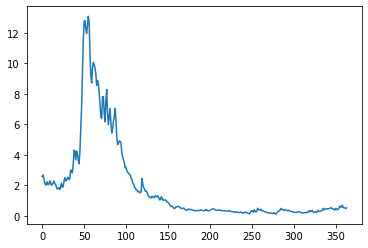

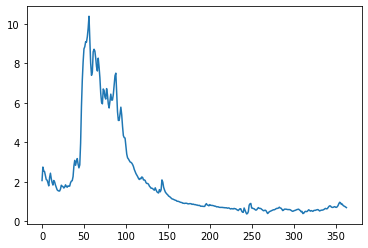

In [35]:
data_plot = y0_batch.cpu().detach().numpy()
plt.plot(data_plot[0, (seq_length - target_seq_length) : (seq_length - 1)])

In [15]:
data_plot[6, (seq_length - target_seq_length) : (seq_length - 1)]

array([], dtype=float32)